In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from matplotlib.ticker import MaxNLocator


In [69]:
# import mc data file
# mcfile = 'mc_data/mc_data_roots100.npy'
# mcfile = '../dsa_mc/testing_pp.npy'
mcfile = '../dsa_mc/trial1_t.npy'
mcdata = np.load(mcfile)
mc_df = pd.DataFrame(mcdata, columns=['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 
                                      'num_dsa', 'den_dsa', '<1>', '<cos(phi_kp)>', '<cos(phi_Dp)>', 
                                     '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>'])

mc_df['t'] = np.abs(mc_df['delta'])**2

# mcfile2 = 'mc_data/mc_data_roots70.npy'
# # mcfile = 'mc_data/testing.npy'
# mcdata2 = np.load(mcfile2)
# mc_df2 = pd.DataFrame(mcdata2, columns=['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 
#                                       'num_dsa', 'den_dsa', '<1>', '<cos(phi_kp)>', '<cos(phi_Dp)>', 
#                                      '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>'])
# mc_df2['t'] = np.abs(mc_df2['delta'])



In [71]:
mc_df.tail()

,s,Q,x,delta,pT,z,y,phi_kp,phi_Dp,num_dsa,den_dsa,<1>,<cos(phi_kp)>,<cos(phi_Dp)>,<cos(phi_Dp)cos(phi_kp)>,<sin(phi_Dp)sin(phi_kp)>,t
9995,9025.0,4.445471,0.008920,0.152407,9.186943,0.331616,0.245475,5.780079,0.529323,12.282561,174.386025,0.127429,-0.021865,0.003101,-0.001565,0.000961,0.023228
9996,9025.0,7.538424,0.006377,0.176308,2.646264,0.883567,0.987343,1.741394,5.178518,508.054463,11130.775607,0.039233,-0.001796,0.005333,0.000564,-0.000184,0.031085
9997,9025.0,4.976001,0.004462,0.158809,7.112009,0.302127,0.614924,0.077027,5.097349,128.776348,1276.038545,0.169791,-0.015276,0.004859,-0.000449,0.001096,0.025220
9998,9025.0,7.377030,0.007065,0.113123,8.845347,0.858144,0.853539,5.864675,3.435197,49.542802,122.450454,0.344932,0.035305,-0.012036,-0.000810,0.001452,0.012797
9999,9025.0,8.127710,0.007582,0.183228,11.300019,0.197832,0.965370,5.846190,5.289332,8.116210,27.278632,0.329600,-0.021241,0.014781,-0.000830,0.001080,0.033572


In [73]:
# function to plot histograms

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 14  
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'

labels = {
         'num_dsa': 'DSA',
         'den_dsa': 'Total',
         '<1>': r'$A_{LL}$',
         '<cos(phi_kp)>': r'$\langle \cos(\phi_{kp}) \rangle$',
         '<cos(phi_Dp)>': r'$\langle \cos(\phi_{\Delta p}) \rangle$',
         '<cos(phi_Dp)cos(phi_kp)>': r'$\langle \cos(\phi_{kp}) \cos(\phi_{\Delta p}) \rangle$',
         '<sin(phi_Dp)sin(phi_kp)>': r'$\langle \sin(\phi_{kp}) \sin(\phi_{\Delta p}) \rangle$'
         }

def plot_histogram(dfs, plot_var, weights, constraints={}, **options):

    # asp_ratio = 6/3
    asp_ratio = 4/3
    psize = 5

    # fig, axs = plt.subplots(1, 2, figsize=(asp_ratio*psize, psize), sharex=True, gridspec_kw={'width_ratios': [5, 1]})
    fig, ax = plt.subplots(1, 1, figsize=(asp_ratio*psize, psize))
    axs = [ax]
        
    colors = ['black', 'red', 'black', 'green']
    linestyles = ['-', '--', '-.']

    lumi = options.get('lumi', 10) # total integrated luminosity in fb^-1
    lumi *= options.get('efficiency', 1) # correct for detector efficiency

    for idf, df in enumerate(dfs):
        
        # make bins
        range = [df[plot_var].min(), df[plot_var].max()]
        nbins = options.get('nbins', 10)
        bin_width = options.get('binwidth', (range[1] - range[0])/nbins)
        bins = options.get('bins', np.arange(np.floor(range[0]/bin_width)*bin_width, np.ceil(range[1]/bin_width)*bin_width, bin_width))

        # enforce constraints
        mask = pd.Series(True, index=df.index)
        for var, (low, high) in constraints.items(): mask &= df[var].between(low, high)
        fixed_df = df[mask]

        if fixed_df.empty:
            print('Error: selected dataframe is empty - constraints are too strict')
            return
    
        for iw in weights: assert iw in list(df.columns), f'Error: option for weight {iw} not recognized'
        
        # make plot data         
        for iw, weight in enumerate(weights):
    
            total_counts, plot_bins = np.histogram(fixed_df[plot_var], bins=bins, weights=fixed_df['den_dsa'])
            plot_counts, _ = np.histogram(fixed_df[plot_var], bins=bins, weights=fixed_df[weight])
            bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])
    
            # ensure bins are properly averaged
            n_entries, _ = np.histogram(fixed_df[plot_var], bins=bins)
            plot_counts = np.array([icount/(bin_width*ientry) if ientry != 0 else 0 for icount, ientry in zip(plot_counts, n_entries)])
            total_counts = np.array([icount/(bin_width*ientry) if ientry != 0 else 0 for icount, ientry in zip(total_counts, n_entries)])
      
            # errors are calculated for a given integrated luminosity (5% systematic error added per 1505.05783)
            if '<' in weight:
                stat_errors = np.array([np.sqrt((1+ic)/(lumi*tc)) if tc != 0 else 0 for ic, tc in zip(plot_counts, total_counts)])
            else:
                stat_errors = np.sqrt(total_counts/lumi)
            sys_errors = 0.05*np.abs(plot_counts)  
            total_errors = np.sqrt((stat_errors**2)+(sys_errors)**2)

            if len(dfs) > 1: plot_label = labels[weight] + f'({idf})'
            else: plot_label = labels[weight] 
    
            # make data plot
            axs[0].errorbar(
                bin_centers, plot_counts, yerr=total_errors,
                fmt=options.get('fmt', 'o'), 
                capsize=3, elinewidth=0.8, capthick=0.0, color=colors[iw + idf],
                label=plot_label,
            )

            axs[0].step(bin_centers, plot_counts, where='mid', linestyle=linestyles[idf], color=colors[iw+idf], linewidth=1)
    
        if len(weights) > 1: axs[0].legend(frameon=False)

        # make info box for kinematics
        info_text = fr'Integrated luminosity: ${lumi}\,\, \mathrm{{fb}}^{{-1}}$'+'\n'
        info_text += fr'$\sqrt{{s}} = {round(np.sqrt(df['s'][0]))}\,\, \mathrm{{GeV}}$'
        # info_text += '\nCuts:'

        for var in ['Q', 'x', 't', 'z']:
            low = fixed_df[var].min()
            high = fixed_df[var].max()
            
            if var == 'Q':
                info_text += '\n'+ fr'${var}^2 \, \in \,[{round(low**2,1)}, \, {round(high**2,1)}]\, \mathrm{{GeV^2}}$'
            elif var == 't':
                info_text += '\n'+ fr'${var} \, \in \,  [{round(low,2)}, \, {round(high,2)}]\, \mathrm{{GeV}}^2$'
            elif var == 'x':
                info_text += '\n'+ fr'${var} \, \in \, [{round(low,3)}, \, {round(high,3)}]$'
            elif var == 'z':
                info_text += '\n' + fr'${var} \, \in \, [{round(low,2)}, \, {round(high,2)}]$'
        
        # axs[1].text(
        #     0.0, 0.0, info_text, 
        #     ha='left', va='bottom', 
        #     fontsize=12, wrap=True, 
        #     bbox=dict(boxstyle='round', facecolor='white', alpha=0.3)
        # )
        # axs[1].set_axis_off()
        axs[0].text(
            0.05, 0.05, info_text, 
            transform=axs[0].transAxes,  # axes-relative coordinates
            ha='left', va='bottom', 
            fontsize=11, wrap=True, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.3, edgecolor='none')
        )

        # set plot info
        if options.get('y_limits'): axs[0].set_ylim(options.get('y_limits'))
        axs[0].set_xlim(options.get('x_limits', [plot_bins[0], plot_bins[-1]]))
        axs[0].set_title(options.get('title', ''))
        axs[0].set_ylabel(options.get('y_label', 'Frequency'), loc='top')
        axs[0].set_xlabel(options.get('x_label', fr'${plot_var}$'), loc='right')
        axs[0].set_yscale(options.get('y_scale', 'linear'))
        axs[0].set_xscale(options.get('x_scale', 'linear'))
        axs[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
        axs[0].grid(options.get('grid', False)) 
        axs[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
        if options.get('zero_line', False): axs[0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
        if options.get('min_pT_line', False) and plot_var == 'pT': 
            axs[0].axvline(x=1, color='gray', linestyle='--')
            axs[0].fill_betweenx(axs[0].get_ylim(), axs[0].get_xlim()[0], 1, color='gray', alpha=0.25)
        plt.tight_layout()
        if options.get('saveas'): 
            if 'DNS' in options.get('saveas'): 
                pass
            else:
                fig.savefig(options.get('saveas'), dpi=400, bbox_inches="tight")




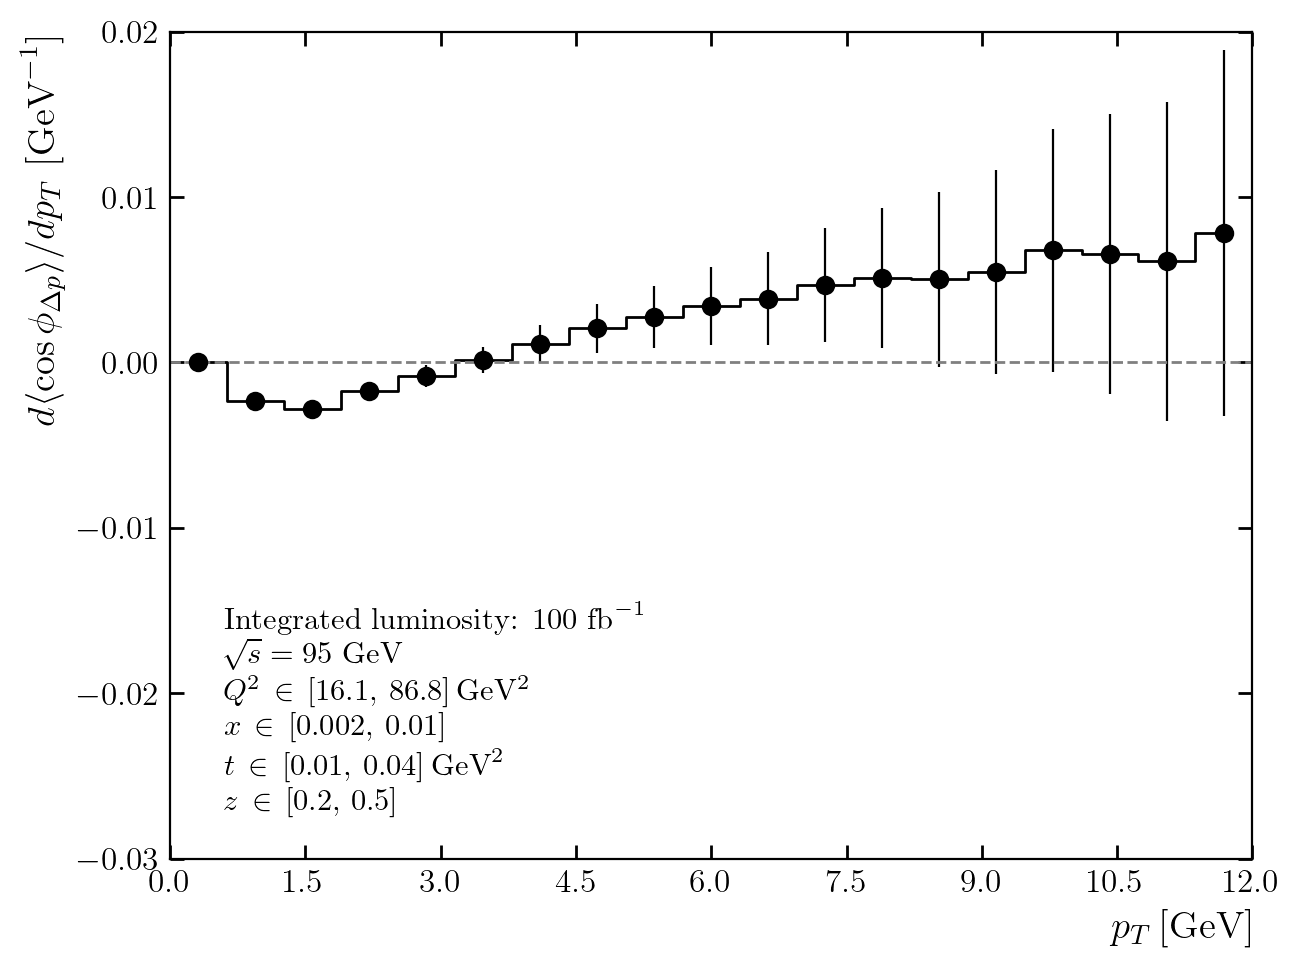

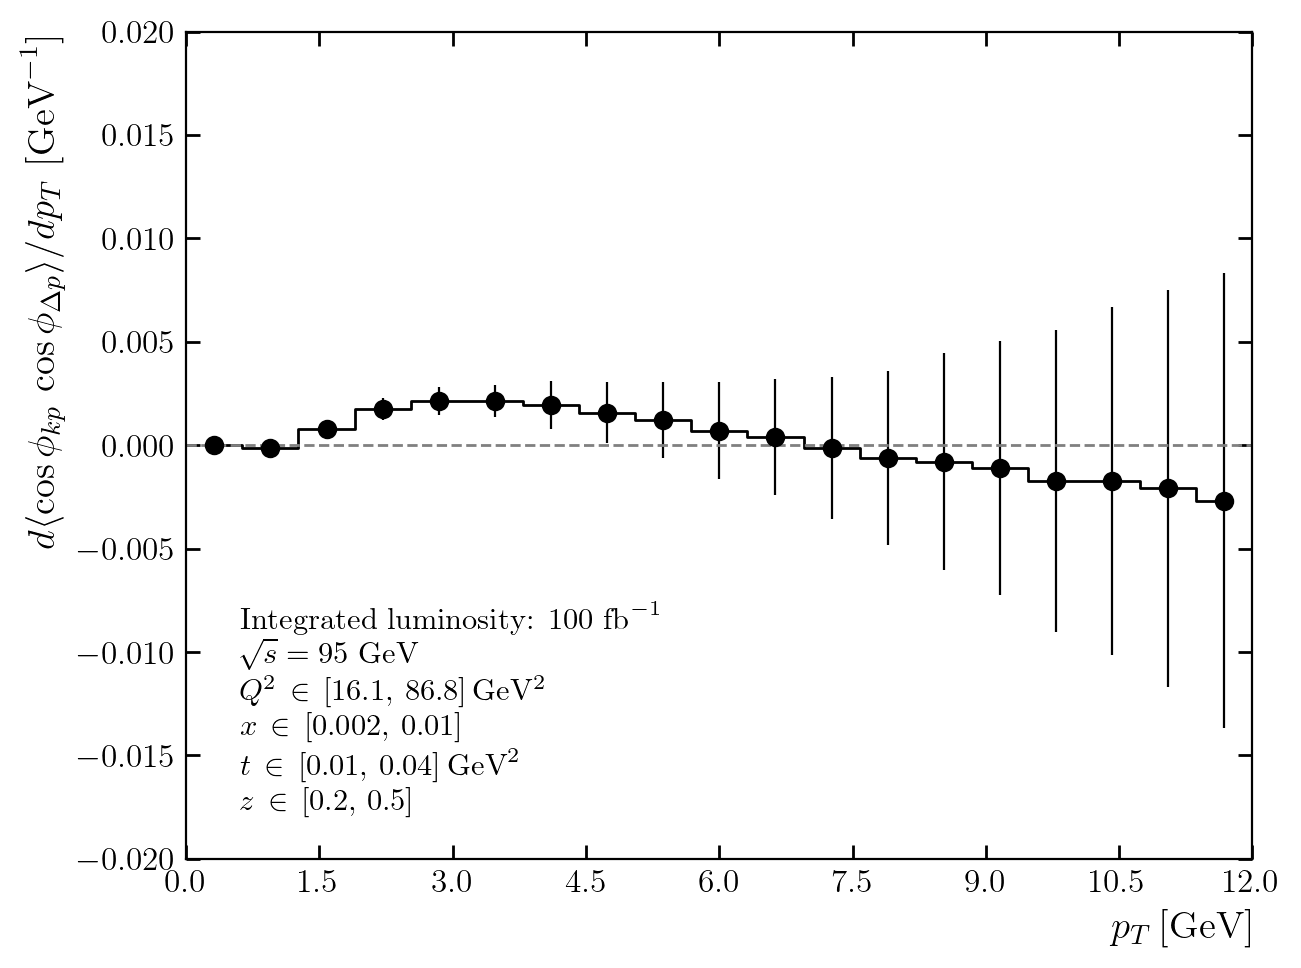

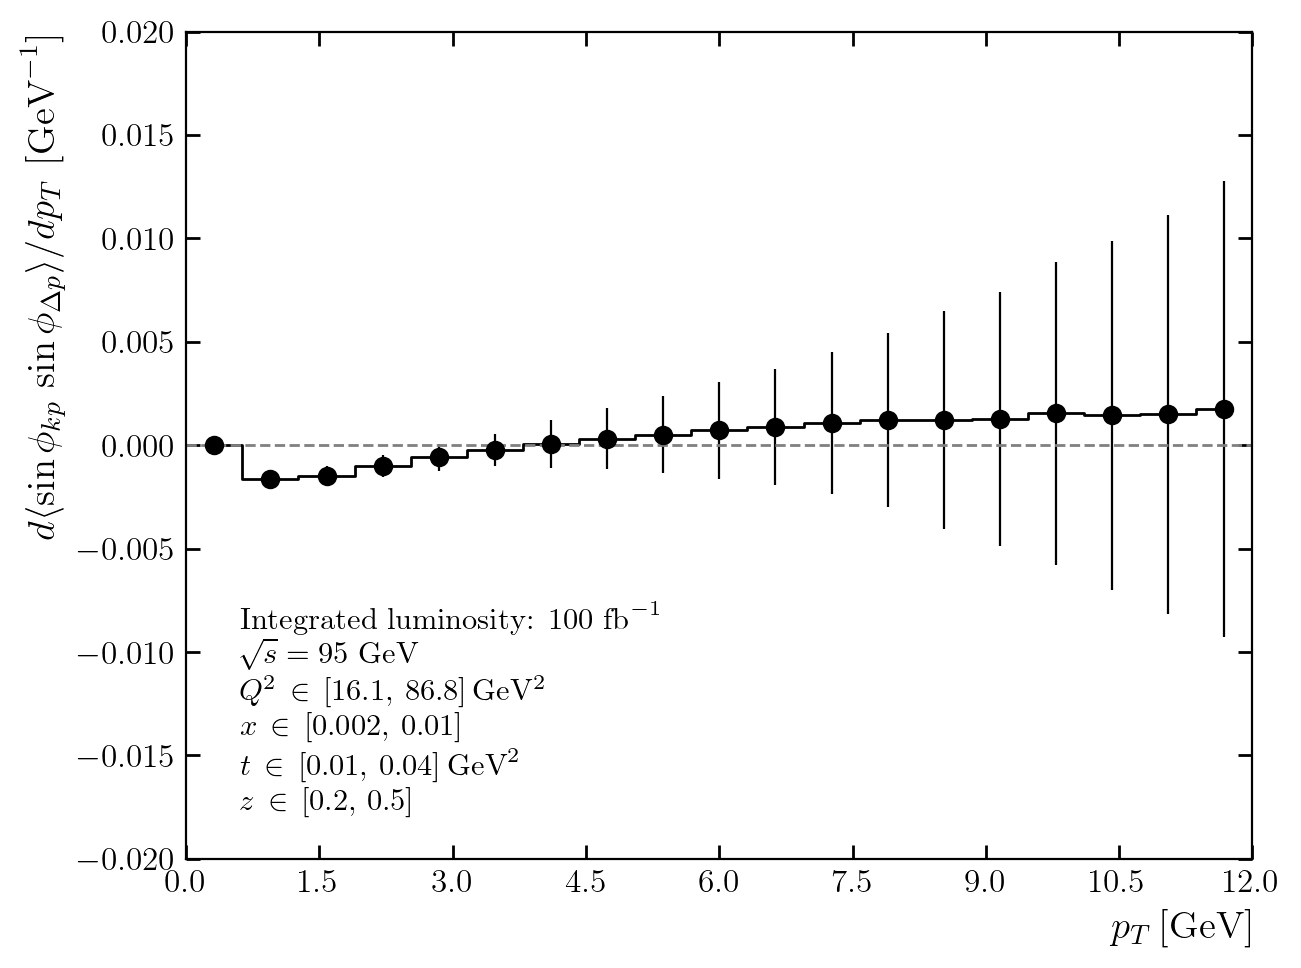

In [77]:
# plot relevant quantities 

Q_bins = np.linspace(6, 10.0, num=25)
pT_bins = np.linspace(0, 12.0, num=20)
phi_bins = [i/(2*np.pi) for i in range(15)]


lumi = 100
Q_min = 6.0 
Q_max = 9.5
y_min = 0.4
y_max = 0.5
z_min = 0.2
z_max = 0.5
x_min = 0.00001
x_max = 0.01

tag = 'DNS'

# plot_histogram([mc_df], 'pT', ['den_dsa', 'num_dsa'], 
#                    {
#                     # 'Q': [Q_min, Q_max],
#                     # 'y': [y_min, y_max],
#                     # 'z': [z_min, z_max],
#                    }, 
#                    lumi = lumi,
#                    bins = pT_bins, 
#                    y_scale='log', 
#                    # x_scale='log',
#                    # x_limits = [0, 11], 
#                    nbins = 20, 
#                    # y_limits = [10,10**9],
#                    # zero_line = True,
#                    min_pT_line = True,
#                    y_label=r'$d\sigma /dp_T \,\,[\mathrm{fb}*\mathrm{GeV}^{-1}]$', 
#                    x_label=r'$p_T\, [\mathrm{GeV}]$',
#                    saveas=f'plots/dsa_pT_{tag}.pdf'
#               )



plot_histogram([mc_df], 'pT', ['<cos(phi_Dp)>'], 
                   {
                    # 'Q': [Q_min, Q_max],
                    # 'pT': [2.5, 3.5]
                    # 'y': [y_min, y_max],
                    'z': [z_min, z_max],
                    # 'x': [x_min, x_max],
                   }, 
                   lumi = lumi,
                   efficiency = 1, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   nbins = 20, 
                   y_limits = [-0.03,0.02],
                   zero_line = True,
                   # min_pT_line = True,
                   y_label=r'$d \langle  \cos \phi_{\Delta p} \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas = f'plots/cos_{tag}.pdf'
                  )


plot_histogram([mc_df], 'pT', ['<cos(phi_Dp)cos(phi_kp)>'], 
                   {
                    # 'Q': [Q_min, Q_max],
                    # 'pT': [2.5, 3.5]
                    # 'y': [y_min, y_max],
                    'z': [z_min, z_max],
                    # 'x': [x_min, x_max],
                   }, 
                   lumi = lumi,
                   efficiency = 1, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   nbins = 20, 
                   y_limits = [-0.02,0.02],
                   zero_line = True,
                   # min_pT_line = True,
                   y_label=r'$d \langle \cos \phi_{kp} \, \cos \phi_{\Delta p} \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas = f'plots/coscos_{tag}.pdf'
                  )


plot_histogram([mc_df], 'pT', ['<sin(phi_Dp)sin(phi_kp)>'], 
                   {
                    # 'Q': [Q_min, Q_max],
                    # 'pT': [2.5, 3.5]
                    # 'y': [y_min, y_max],
                    'z': [z_min, z_max],
                    # 'x': [x_min, x_max],
                   }, 
                   lumi = lumi,
                   efficiency = 1, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   nbins = 20, 
                   y_limits = [-0.02,0.02],
                   zero_line = True,
                   # min_pT_line = True,
                   y_label=r'$d \langle \sin \phi_{kp} \, \sin \phi_{\Delta p} \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas = f'plots/sinsin_{tag}.pdf'
                  )




# plot_histogram([mc_df], 'pT', ['<1>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>','<cos(phi_Dp)>'], 
#                    {
#                     'Q': [Q_min, Q_max],
#                     # 'pT': [2.5, 3.5]
#                     # 'y': [y_min, y_max],
#                     'z': [z_min, z_max],
#                     'x': [x_min, x_max],
#                    }, 
#                    lumi = lumi,
#                    efficiency = 1, 
#                    # y_scale='log', 
#                    # x_scale='log',
#                    # x_limits = [5, 11], 
#                    bins = pT_bins,
#                    nbins = 20, 
#                    y_limits = [-0.1,0.65],
#                    zero_line = True,
#                    min_pT_line = True,
#                    y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
#                    x_label=r'$p_T\, [\mathrm{GeV}]$',
#                    saveas = f'plots/all_corr_{tag}.pdf'
#                   )


